In [348]:
import pandas as pd
import numpy as np
import os

In [349]:
local_dataset_dir = "../dataset/"
local_dataset_file_path = os.path.join(local_dataset_dir, "laptops.csv")

In [350]:
if not os.path.exists(local_dataset_file_path):
  !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv -P "../dataset/"
else:
  print("The dataset file already exists. No need to download it again")

The dataset file already exists. No need to download it again


In [351]:
df = pd.read_csv("../dataset/laptops.csv")

In [352]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [353]:
df = df[['ram','storage','screen', 'final_price']]

In [354]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<Axes: xlabel='final_price', ylabel='Count'>

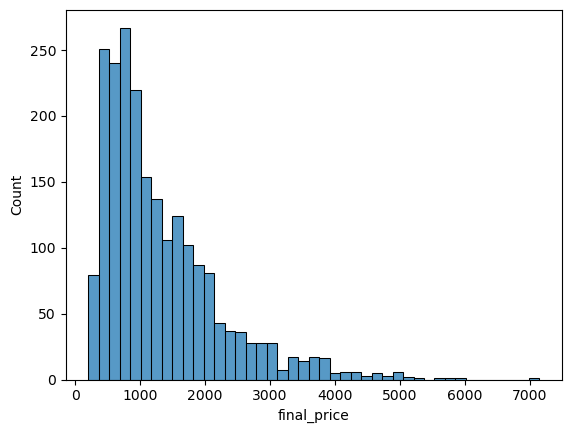

In [355]:
sns.histplot(df.final_price)

In [356]:
df.columns[df.isnull().any()].tolist()

['screen']

In [357]:
df['ram'].median()

16.0

In [358]:
n=len(df)
n_val = int(n*0.2)
n_test = int(n*0.2)
n_train=n -n_val-n_test

In [359]:
idx=np.arange(n)

In [360]:
np.random.seed(42)
np.random.shuffle(idx)

In [361]:
df_train=df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]


In [362]:
df_train=df_train.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)

In [363]:
screen_mean=df_train['screen'].mean().round(1)
screen_mean

15.2

In [364]:
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

In [365]:
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [366]:
df_train_mean = df_train.copy()
df_val_mean = df_val.copy()
df_test_mean = df_test.copy()

In [367]:
df_train_mean['screen']=df_train_mean['screen'].fillna(screen_mean)
df_val_mean['screen'] = df_val_mean['screen'].fillna(screen_mean)
df_test_mean['screen'] = df_test_mean['screen'].fillna(screen_mean)

In [368]:
def train_linear_regression(X,y):
    ones= np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [369]:
w0, w = train_linear_regression(df_train_mean, y_train)
w0, w

(808.7022721594524, array([ 43.90756394,   0.87133126, -45.16736577]))

In [370]:
y_pred_mean = w0+df_train_mean.dot(w)

<Axes: ylabel='Count'>

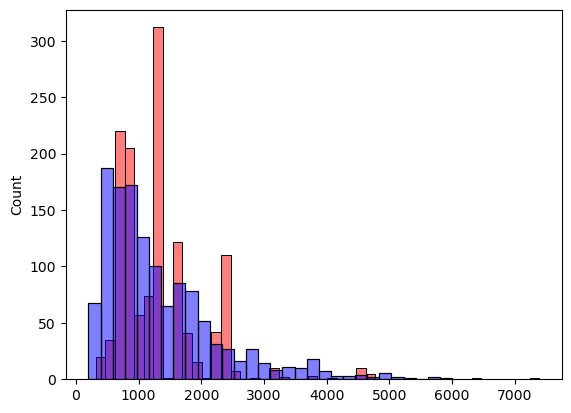

In [371]:
sns.histplot(y_pred_mean, color='red', alpha=0.5)
sns.histplot(y_train, color = 'blue', alpha=0.5)

In [372]:
def rsme(y, y_pred):
    error = y-y_pred
    se = error **2
    mse = se.mean()
    return np.sqrt(mse)

In [373]:
score_train_mean = rsme(y_train, y_pred_mean)
round(score_train_mean,2)

602.19

In [374]:
y_val_pred_mean = w0+df_val_mean.dot(w)


In [375]:
score_val_mean = rsme(y_val, y_val_pred_mean)
round(score_val_mean,2)

600.27

In [376]:
df_train_zeros = df_train.copy()
df_val_zeros = df_val.copy()
df_test_zeros = df_test.copy()

In [377]:
df_train_zeros['screen']=df_train_zeros['screen'].fillna(0)
df_val_zeros['screen'] = df_val_zeros['screen'].fillna(0)
df_test_zeros['screen'] = df_test_zeros['screen'].fillna(0)

In [378]:
w0, w = train_linear_regression(df_train_zeros, y_train)
w0, w

(676.8954853010354, array([ 43.70681555,   0.86506867, -36.10399833]))

In [379]:
y_pred_zeros = w0 + df_train_zeros.dot(w)

In [380]:
score_train_zeros = rsme(y_train, y_pred_zeros)
round(score_train_zeros, 2)

602.39

In [381]:
y_val_pred_zeros = w0+df_val_zeros.dot(w)

In [382]:
score_val_zeros = rsme(y_val, y_val_pred_zeros)
round(score_val_zeros, 2)

597.36

In [383]:
def train_linear_regression_reg(X,y, r):
    ones= np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [384]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w0, w = train_linear_regression_reg(df_train_zeros, y_train, r=r)
    y_pred = w0 + df_val_zeros.dot(w)
    score = round(rsme(y_val, y_pred),2)
    print (r, score)

0 597.36
0.01 597.36
0.1 597.35
1 597.21
5 597.01
10 597.06
100 597.9


In [385]:
def prepare_and_train_linear_regression(df, seed):
    df = df.copy()
    df['screen'] = df['screen'].fillna(0)
    
    rows = df.shape[0]
    n_test = int(rows * 0.20)
    n_val = int(rows * 0.20)
    n_train = rows-n_test-n_val

    idx=np.arange(rows)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]
    
    df_train=df_train.reset_index(drop=True)
    df_val=df_val.reset_index(drop=True)
    df_test=df_test.reset_index(drop=True) 

    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values  

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']    

    w0, w = train_linear_regression(df_train, y_train)
    y_pred = w0 + df_val.dot(w)
    score = rsme(y_val, y_pred)
    
    return score

In [386]:
scores = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    score = prepare_and_train_linear_regression(df, seed)
    scores.append(score)
print(scores)
std = round(np.std(scores), 3)
std

[565.4520868770965, 636.7985423056713, 588.9558697907975, 597.8148920012538, 571.9627915111048, 573.2383256618931, 647.3438328407295, 550.4398184485883, 587.3335036169867, 576.1017929433073]


29.176

In [387]:
seed = 9
df = df.copy()
df['screen'] = df['screen'].fillna(0)

rows = len(df)
idx=np.arange(rows)
np.random.seed(seed)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train = pd.concat([df_train, df_val], ignore_index=True)
df_test=df_test.reset_index(drop=True) 

y_train = df_train.final_price.values
y_test = df_test.final_price.values  

del df_train['final_price']
del df_test['final_price']    

w0, w = train_linear_regression_reg(df_train, y_train, 0.001)
y_pred = w0 + df_test.dot(w)
score = rsme(y_test, y_pred)

score

608.60998220496